Get the prerequisites done

In [1]:
! pip install kaggle --upgrade --force

     |████████████████████████████████| 58 kB 2.5 MB/s 
     |████████████████████████████████| 149 kB 11.4 MB/s 
     |████████████████████████████████| 247 kB 52.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 138 kB 37.0 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 61 kB 7.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=038ea399e07371129f1ca2600e0d1e8b8916e735a63059b6319b24dbc4260f3f
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: text-unidecode
    Found existing installation: text-unidecode 1.3
    Uninstal

In [2]:
import os
gce=False
if 'NO_GCE_CHECK' in os.environ:
  gce = True
if gce:
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'
else:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! kaggle competitions download -c song-popularity-prediction

song-popularity-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
! unzip song-popularity-prediction.zip

Archive:  song-popularity-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
! pwd

/content


In [6]:
! ls

drive	     sample_submission.csv	     test.csv
sample_data  song-popularity-prediction.zip  train.csv


In [514]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, RobustScaler, OrdinalEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split, StratifiedKFold, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import SCORERS, roc_auc_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats.distributions import norm, lognorm, uniform
set_config(display='diagram')

In [8]:
np.random.seed(1)

In [818]:
df = pd.read_csv('train.csv').set_index("id")
test_df = pd.read_csv('test.csv').set_index("id")

In [819]:
df.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
id,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [820]:
def detect_outliers(df, threshold):
    # https://www.kaggle.com/kavehshahhosseini/spp-eda-feature-engineering-blending
    df = df.copy()
    threshold_z_score = stats.norm.ppf(threshold) # the 6 sigma plot, convert percentile (quantile) to Zscore.
    z_score_df = pd.DataFrame(np.abs(stats.zscore(df)), columns=df.columns)
    z_score_df = z_score_df > threshold_z_score # if greater than 99.99% of the data, count as outlier.
    outliers = z_score_df.sum(axis=1) # sum across columns along each row
    df["is_outlier"] = (outliers > 0).astype("uint8")
    return df

In [821]:
z_score_threshold = 0.9999

In [822]:
# outlier_df_train = detect_outliers(df, threshold=z_score_threshold)

In [823]:
# df = outlier_df_train[outlier_df_train.is_outlier==0].copy()

In [824]:
# df.drop('is_outlier', inplace=True, axis=1)

In [825]:
df.columns

Index(['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
       'speechiness', 'tempo', 'time_signature', 'audio_valence',
       'song_popularity'],
      dtype='object')

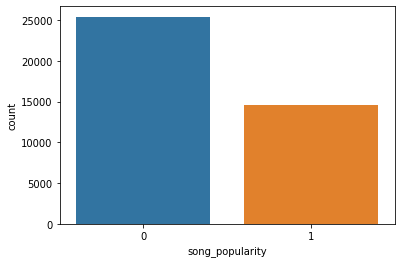

In [826]:
sns.countplot(data=df, x='song_popularity')

In [827]:
df.song_popularity.value_counts()

0    25424
1    14576
Name: song_popularity, dtype: int64

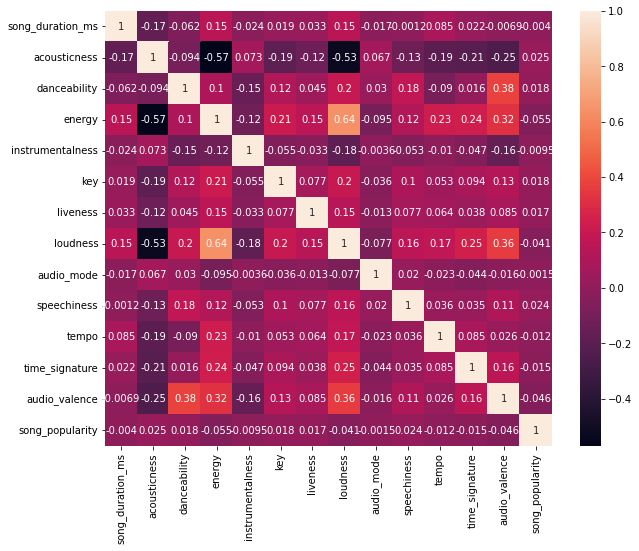

In [828]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

In [829]:
counts = df.song_popularity.value_counts()
counts/counts.sum()

0    0.6356
1    0.3644
Name: song_popularity, dtype: float64

In [830]:
def resample(df, frac_1=1, frac_0=1):
  df_1 = df[df.song_popularity==1].sample(frac=frac_1, replace=False)
  df_0 = df[df.song_popularity==0].sample(frac=frac_0, replace=False)
  df = pd.concat([df_1, df_0]).sample(frac=1, replace=False)
  df.reset_index(inplace=True, drop=True)
  return df

In [831]:
train_df = resample(df, frac_0=0.8, frac_1=1)

In [832]:
train_df.song_popularity.value_counts()

0    25424
1    14576
Name: song_popularity, dtype: int64

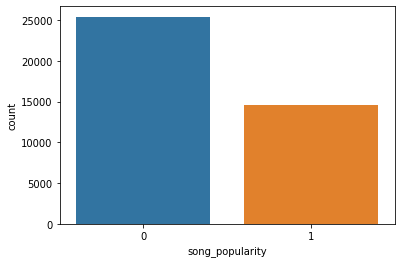

In [833]:
sns.countplot(data=train_df, x='song_popularity')

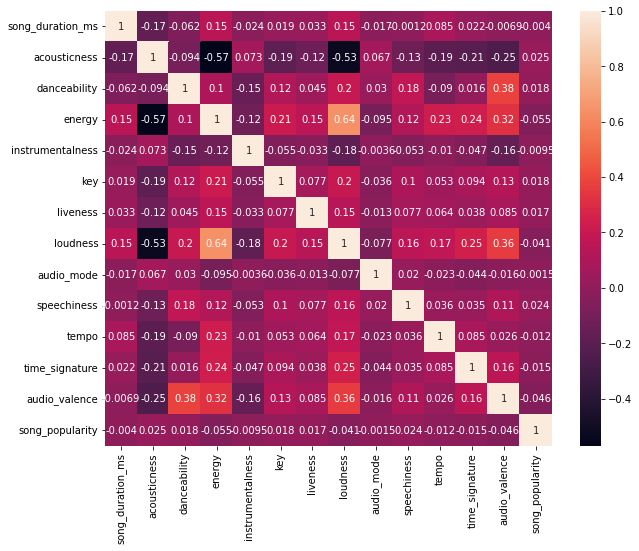

In [834]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), annot=True)

In [835]:
train_df.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,187058.0,0.904534,0.688940,0.283188,0.001949,0.0,0.142559,-13.199083,0,0.068592,94.313245,3,0.348771,0
1,160125.0,0.656761,0.232294,0.506886,0.004779,2.0,0.103102,-15.724810,1,0.032255,92.963149,3,0.153064,1
2,236736.0,0.337662,0.710092,0.894939,0.760129,7.0,0.102694,-5.280655,0,0.057633,119.377608,3,0.485584,0
3,176346.0,0.172574,0.380527,NaN,0.001503,1.0,0.125469,-9.956446,0,0.069992,98.965274,3,0.303569,1
4,136114.0,NaN,0.801165,0.790765,0.002489,NaN,0.115499,-5.614071,0,0.055671,96.893229,3,0.912562,1


In [836]:
train_df["log_ins"] = np.log(train_df.instrumentalness)
train_df.drop('instrumentalness', inplace=True, axis=1)

test_df["log_ins"] = np.log(test_df.instrumentalness)
test_df.drop('instrumentalness', inplace=True, axis=1)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


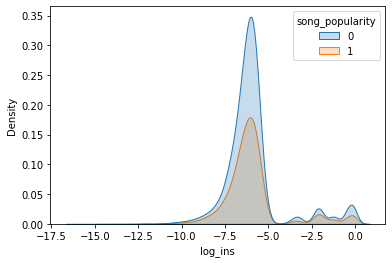

In [837]:
sns.kdeplot(data=train_df, x='log_ins', hue='song_popularity', fill=True)

Milliseconds to Minutes

In [838]:
train_df["song_duration_m"] = train_df.song_duration_ms.copy()/60000.
train_df.drop('song_duration_ms', inplace=True, axis=1)

test_df["song_duration_m"] = test_df.song_duration_ms.copy()/60000.
test_df.drop('song_duration_ms', inplace=True, axis=1)


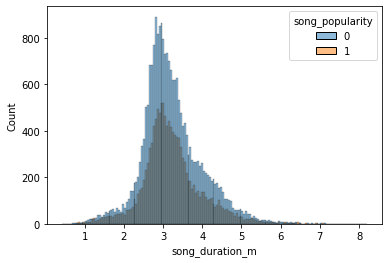

In [839]:
sns.histplot(data=train_df, x='song_duration_m', hue='song_popularity')

In [840]:
target_col = 'song_popularity'

# Discretize continuous columns to make categories

Not plotting actual vales for cont variables, since we sclaed.

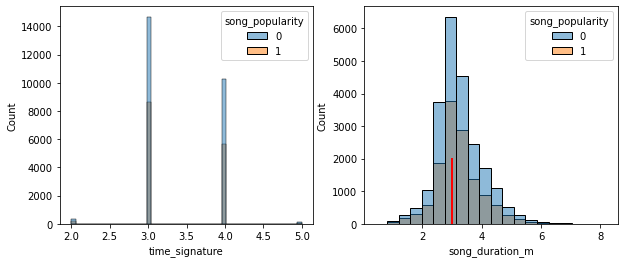

In [841]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=train_df, x='time_signature', hue=target_col)
plt.subplot(1,2,2)
sns.histplot(data=train_df, x='song_duration_m', hue=target_col, bins=20)
plt.plot([3, 3], [0, 2000], linewidth=2, color='red')

In [842]:
train_df.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,log_ins,song_duration_m
0,0.904534,0.688940,0.283188,0.0,0.142559,-13.199083,0,0.068592,94.313245,3,0.348771,0,-6.240677,3.117633
1,0.656761,0.232294,0.506886,2.0,0.103102,-15.724810,1,0.032255,92.963149,3,0.153064,1,-5.343468,2.668750
2,0.337662,0.710092,0.894939,7.0,0.102694,-5.280655,0,0.057633,119.377608,3,0.485584,0,-0.274267,3.945600
3,0.172574,0.380527,NaN,1.0,0.125469,-9.956446,0,0.069992,98.965274,3,0.303569,1,-6.500071,2.939100
4,NaN,0.801165,0.790765,NaN,0.115499,-5.614071,0,0.055671,96.893229,3,0.912562,1,-5.995917,2.268567


Raw data is categorical.

In [843]:
cat_cols = ['key', 'audio_mode', 'time_signature'] 

Raw data is continuous but make categorical.

In [844]:
cont_2_cat = ['log_ins', 'tempo', 'song_duration_m', 'energy', 'loudness']

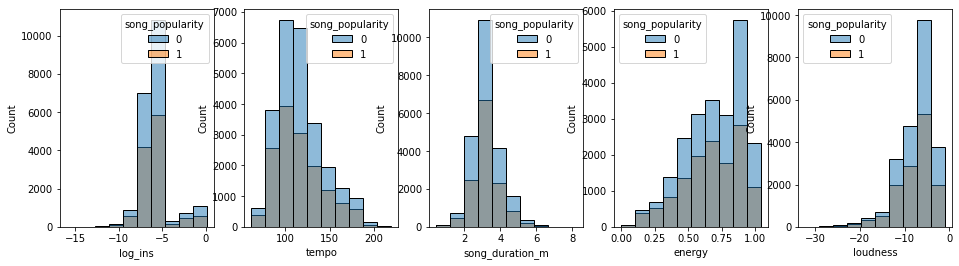

In [845]:
plt.figure(figsize=(16,4))
for i, col in enumerate(cont_2_cat):
  plt.subplot(1,5,i+1)
  sns.histplot(data=train_df, x=col, hue=target_col, bins=10)

Preserve continuous data

In [846]:
preserve_cols = ['log_ins', 'song_duration_m', 'tempo', 'energy']
preserve_cols_as = ['log_ins_cont', 'song_duration_m_cont', 'tempo_cont', 'energy_cont']
train_df[preserve_cols_as] = train_df[preserve_cols]
test_df[preserve_cols_as] = test_df[preserve_cols]

In [847]:
train_df.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont
0,0.904534,0.688940,0.283188,0.0,0.142559,-13.199083,0,0.068592,94.313245,3,0.348771,0,-6.240677,3.117633,-6.240677,3.117633,94.313245,0.283188
1,0.656761,0.232294,0.506886,2.0,0.103102,-15.724810,1,0.032255,92.963149,3,0.153064,1,-5.343468,2.668750,-5.343468,2.668750,92.963149,0.506886
2,0.337662,0.710092,0.894939,7.0,0.102694,-5.280655,0,0.057633,119.377608,3,0.485584,0,-0.274267,3.945600,-0.274267,3.945600,119.377608,0.894939
3,0.172574,0.380527,NaN,1.0,0.125469,-9.956446,0,0.069992,98.965274,3,0.303569,1,-6.500071,2.939100,-6.500071,2.939100,98.965274,NaN
4,NaN,0.801165,0.790765,NaN,0.115499,-5.614071,0,0.055671,96.893229,3,0.912562,1,-5.995917,2.268567,-5.995917,2.268567,96.893229,0.790765


# Trying out imputers before discretizing

In [848]:
has_nan = train_df.notna().sum() != train_df.shape[0]

In [849]:
impute_cols = has_nan.index[has_nan].to_list()
impute_cols

['acousticness',
 'danceability',
 'energy',
 'key',
 'liveness',
 'loudness',
 'log_ins',
 'song_duration_m',
 'log_ins_cont',
 'song_duration_m_cont',
 'energy_cont']

In [850]:
si = SimpleImputer()

In [851]:
ii = IterativeImputer(n_nearest_features=10)

In [852]:
kni = KNNImputer(n_neighbors=10)

Create train and test splits. Do CV on train idxs and test on test idxs.

In [853]:
ssplit = StratifiedKFold(n_splits=2)

In [854]:
for (train_idx, test_idx) in ssplit.split(train_df.drop(target_col, axis=1), train_df[target_col]):
  print(train_idx.shape, test_idx.shape)
  break

len([i for i in train_idx if i in test_idx]) # =0

(20000,) (20000,)


0

In [855]:
for imputer in [si, ii, kni]:
  n_splits=4
  _data_ = train_df[impute_cols].iloc[train_idx]
  _target_ = train_df[target_col].iloc[train_idx]
  _data_test = train_df[impute_cols].iloc[test_idx]
  _target_test = train_df[target_col].iloc[test_idx]

  _data_ = imputer.fit_transform(_data_)
  _data_test = imputer.transform(_data_test)

  cv_results = cross_validate(LogisticRegression(max_iter=50, solver='liblinear'), _data_, _target_, cv=n_splits, 
                              scoring='roc_auc', return_train_score=True, return_estimator=True)
  
  holdout = sum([m.score(_data_test,_target_test) for m in cv_results['estimator']])/n_splits

  print(f"{imputer.__str__()}, train_cv: {cv_results['train_score'].mean():.4f},  test_cv: {cv_results['test_score'].mean():.4f} holdout: {holdout:.4f}")

SimpleImputer(), train_cv: 0.5445,  test_cv: 0.5417 holdout: 0.6358
IterativeImputer(n_nearest_features=10), train_cv: 0.5450,  test_cv: 0.5424 holdout: 0.6357
KNNImputer(n_neighbors=10), train_cv: 0.5474,  test_cv: 0.5451 holdout: 0.6357


KNN imputer seems to work best.

In [856]:
impute_cols

['acousticness',
 'danceability',
 'energy',
 'key',
 'liveness',
 'loudness',
 'log_ins',
 'song_duration_m',
 'log_ins_cont',
 'song_duration_m_cont',
 'energy_cont']

In [857]:
x = train_df.copy()
t = test_df.copy()

x[impute_cols] = kni.fit_transform(x[impute_cols]) # fit and transform the train data
t[impute_cols] = kni.transform(t[impute_cols]) # but only transform for test data

In [858]:
x.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont
0,0.904534,0.688940,0.283188,0.0,0.142559,-13.199083,0,0.068592,94.313245,3,0.348771,0,-6.240677,3.117633,-6.240677,3.117633,94.313245,0.283188
1,0.656761,0.232294,0.506886,2.0,0.103102,-15.724810,1,0.032255,92.963149,3,0.153064,1,-5.343468,2.668750,-5.343468,2.668750,92.963149,0.506886
2,0.337662,0.710092,0.894939,7.0,0.102694,-5.280655,0,0.057633,119.377608,3,0.485584,0,-0.274267,3.945600,-0.274267,3.945600,119.377608,0.894939
3,0.172574,0.380527,0.742765,1.0,0.125469,-9.956446,0,0.069992,98.965274,3,0.303569,1,-6.500071,2.939100,-6.500071,2.939100,98.965274,0.742765
4,0.168737,0.801165,0.790765,5.1,0.115499,-5.614071,0,0.055671,96.893229,3,0.912562,1,-5.995917,2.268567,-5.995917,2.268567,96.893229,0.790765


In [859]:
x.time_signature.value_counts()

3    23358
4    15919
2      530
5      193
Name: time_signature, dtype: int64

In [860]:
kbd = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

In [861]:
cont_2_cat.append('key')

In [862]:
cont_2_cat = cont_2_cat+preserve_cols
cont_2_cat

['log_ins',
 'tempo',
 'song_duration_m',
 'energy',
 'loudness',
 'key',
 'log_ins',
 'song_duration_m',
 'tempo',
 'energy']

In [863]:
x[cont_2_cat] = kbd.fit_transform(x[cont_2_cat]) # fit and transform the train data
t[cont_2_cat] = kbd.transform(t[cont_2_cat]) # but only transform for valid data

In [864]:
x.dtypes

acousticness            float64
danceability            float64
energy                  float64
key                     float64
liveness                float64
loudness                float64
audio_mode                int64
speechiness             float64
tempo                   float64
time_signature            int64
audio_valence           float64
song_popularity           int64
log_ins                 float64
song_duration_m         float64
log_ins_cont            float64
song_duration_m_cont    float64
tempo_cont              float64
energy_cont             float64
dtype: object

In [865]:
cat_cols += cont_2_cat

In [866]:
cat_cols = [*{*cat_cols}]

In [867]:
cat_cols

['key',
 'song_duration_m',
 'audio_mode',
 'time_signature',
 'energy',
 'tempo',
 'loudness',
 'log_ins']

In [868]:
cont_cols = x.columns.to_list()

In [869]:
cont_cols = [c for c in cont_cols if c not in cat_cols if c not in target_col]

In [870]:
cont_cols

['acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont']

In [871]:
feature_cols = [c for c in cat_cols+cont_cols if c!=target_col]

In [872]:
feature_cols

['key',
 'song_duration_m',
 'audio_mode',
 'time_signature',
 'energy',
 'tempo',
 'loudness',
 'log_ins',
 'acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont']

# New features
https://developer.spotify.com/discover/

Mood: Danceability, Valence, Energy, Tempo

Properties: Loudness, Speechiness, Instrumentalness

Context: Liveness, Acousticness

Segments, Tatums, Bars, Beats, Pitches, Timbre, and more

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

In [873]:
x["is_live"] = (x.liveness>=0.8).astype(int)
t["is_live"] = (t.liveness>=0.8).astype(int)

In [874]:
cat_cols.append("is_live")

In [875]:
feature_cols.append("is_live")

In [876]:
x.is_live.sum(), t.is_live.sum()

(195, 47)

In [877]:
kbd_2 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

In [878]:
x['speechiness_level'] = kbd_2.fit_transform(x['speechiness'].values.reshape(-1,1))
t['speechiness_level'] = kbd_2.transform(t['speechiness'].values.reshape(-1,1))

In [879]:
cat_cols.append("speechiness_level")
feature_cols.append("speechiness_level")

In [880]:
x['cat_valence'] = kbd_2.fit_transform(x['audio_valence'].values.reshape(-1,1))
t['cat_valence'] = kbd_2.transform(t['audio_valence'].values.reshape(-1,1))

In [881]:
cat_cols.append("cat_valence")
feature_cols.append("cat_valence")

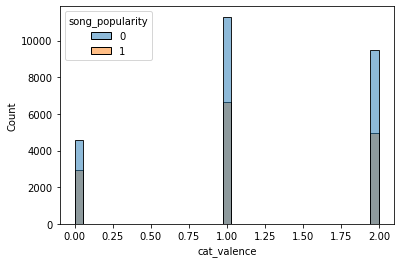

In [882]:
sns.histplot(data=x, x='cat_valence', hue=target_col)

In [883]:
# https://music.stackexchange.com/questions/90286/how-long-is-a-bar
x['t_bar'] = ((1/x.time_signature)*4)
t['t_bar'] = ((1/t.time_signature)*4) # seconds per bar

In [884]:
((1/x.time_signature)*4).value_counts()

1.333333    23358
1.000000    15919
2.000000      530
0.800000      193
Name: time_signature, dtype: int64

In [885]:
# StandardScaler()

In [886]:
cont_cols.append("t_bar")
feature_cols.append("t_bar")

In [887]:
x.t_bar.value_counts()

1.333333    23358
1.000000    15919
2.000000      530
0.800000      193
Name: t_bar, dtype: int64

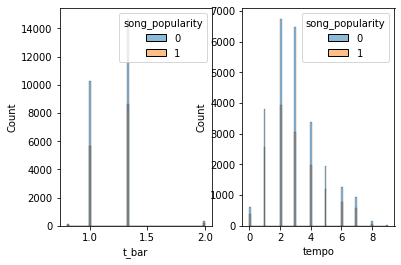

In [888]:
plt.subplot(1,2,1)
sns.histplot(data=x, x='t_bar', hue=target_col)
plt.subplot(1,2,2)
sns.histplot(data=x, x='tempo', hue=target_col)

In [889]:
x.loudness

0        6.0
1        5.0
2        8.0
3        7.0
4        8.0
        ... 
39995    7.0
39996    8.0
39997    7.0
39998    8.0
39999    9.0
Name: loudness, Length: 40000, dtype: float64

In [900]:
x["f1"] = x.audio_valence**x.loudness
t["f1"] = t.audio_valence**t.loudness

In [901]:
x["f2"] = 1/np.exp(x.audio_valence)
t["f2"] = 1/np.exp(t.audio_valence)

In [902]:
x.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,cat_valence,t_bar,f1,f2
0,0.904534,0.688940,2.0,0.0,0.142559,6.0,0,0.068592,2.0,3,0.348771,0,6.0,3.0,-6.240677,3.117633,94.313245,0.283188,0,0.0,0.0,1.333333,0.001800,0.705555
1,0.656761,0.232294,4.0,1.0,0.103102,5.0,1,0.032255,1.0,3,0.153064,1,6.0,2.0,-5.343468,2.668750,92.963149,0.506886,0,0.0,0.0,1.333333,0.000084,0.858075
2,0.337662,0.710092,8.0,6.0,0.102694,8.0,0,0.057633,3.0,3,0.485584,0,9.0,4.0,-0.274267,3.945600,119.377608,0.894939,0,0.0,1.0,1.333333,0.003091,0.615338
3,0.172574,0.380527,7.0,0.0,0.125469,7.0,0,0.069992,2.0,3,0.303569,1,5.0,3.0,-6.500071,2.939100,98.965274,0.742765,0,0.0,0.0,1.333333,0.000238,0.738179
4,0.168737,0.801165,7.0,4.0,0.115499,8.0,0,0.055671,2.0,3,0.912562,1,6.0,2.0,-5.995917,2.268567,96.893229,0.790765,0,0.0,2.0,1.333333,0.480950,0.401494


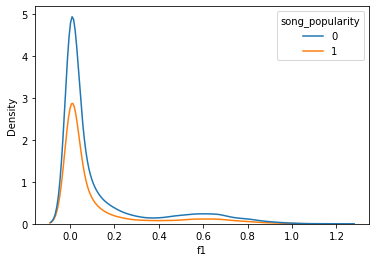

In [903]:
sns.kdeplot(data=x, x="f1", hue="song_popularity")

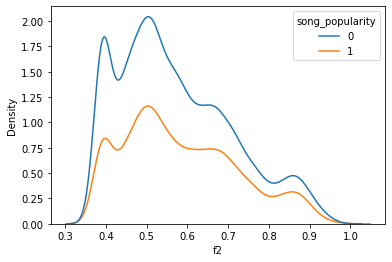

In [904]:
sns.kdeplot(data=x, x="f2", hue="song_popularity")

In [905]:
cont_cols

['acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont',
 't_bar']

In [906]:
cont_cols += ["f1", "f2"]

In [907]:
feature_cols += ["f1", "f2"]
feature_cols

['key',
 'song_duration_m',
 'audio_mode',
 'time_signature',
 'energy',
 'tempo',
 'loudness',
 'log_ins',
 'acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont',
 'is_live',
 'speechiness_level',
 'cat_valence',
 't_bar',
 'f1',
 'f2']

# Cluster distance as a feature

Read that year is a good feature, so assuming 100 years of data, take that as 10 centuries

In [909]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=1)

In [910]:
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]
# gives distance to cluster center for each sample # to get cluster as number, do predict
# since this is a fit transform and not a fit predict
x_cd = kmeans.fit_transform(x[feature_cols])
x_cd = pd.DataFrame(x_cd, columns=cluster_cols, index=x.index)
x = pd.concat([x,x_cd], axis=1)

In [911]:
x.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,cat_valence,t_bar,f1,f2,cluster1,cluster2,cluster3
0,0.904534,0.688940,2.0,0.0,0.142559,6.0,0,0.068592,2.0,3,0.348771,0,6.0,3.0,-6.240677,3.117633,94.313245,0.283188,0,0.0,0.0,1.333333,0.001800,0.705555,5.618378,69.256536,29.811354
1,0.656761,0.232294,4.0,1.0,0.103102,5.0,1,0.032255,1.0,3,0.153064,1,6.0,2.0,-5.343468,2.668750,92.963149,0.506886,0,0.0,0.0,1.333333,0.000084,0.858075,4.553035,70.558764,30.928124
2,0.337662,0.710092,8.0,6.0,0.102694,8.0,0,0.057633,3.0,3,0.485584,0,9.0,4.0,-0.274267,3.945600,119.377608,0.894939,0,0.0,1.0,1.333333,0.003091,0.615338,26.439799,44.455070,8.076030
3,0.172574,0.380527,7.0,0.0,0.125469,7.0,0,0.069992,2.0,3,0.303569,1,5.0,3.0,-6.500071,2.939100,98.965274,0.742765,0,0.0,0.0,1.333333,0.000238,0.738179,6.719920,64.478023,24.830339
4,0.168737,0.801165,7.0,4.0,0.115499,8.0,0,0.055671,2.0,3,0.912562,1,6.0,2.0,-5.995917,2.268567,96.893229,0.790765,0,0.0,2.0,1.333333,0.480950,0.401494,3.853539,66.421648,26.487839


In [912]:
x_cd = kmeans.transform(t[feature_cols]) # dont fit for test
x_cd = pd.DataFrame(x_cd, columns=cluster_cols, index=t.index)
t = pd.concat([t,x_cd], axis=1)
t.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,cat_valence,t_bar,f1,f2,cluster1,cluster2,cluster3
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.019845,0.576416,8.0,6.0,0.112832,7.0,0,0.082714,4.0,4,0.399620,5.0,6.0,-6.544156,5.142050,126.129304,0.908939,0,0.0,1.0,1.000000,0.001628,0.670575,32.583269,37.339705,5.124116
1,0.070119,0.731256,4.0,9.0,0.139040,8.0,0,0.061685,1.0,3,0.499424,6.0,3.0,-6.204810,3.333517,86.448149,0.444655,0,0.0,1.0,1.333333,0.003870,0.606880,9.328816,77.064686,37.283996
2,0.810637,0.568858,1.0,0.0,0.226614,6.0,0,0.041868,2.0,3,0.564951,9.0,5.0,-0.106649,4.662633,99.544351,0.125466,0,0.0,1.0,1.333333,0.032513,0.568388,10.846628,64.510223,25.948461
3,0.295514,0.871789,5.0,3.0,0.325391,7.0,1,0.046815,3.0,4,0.906485,5.0,4.0,-7.243249,4.153283,123.063854,0.557342,0,0.0,2.0,1.000000,0.502951,0.403941,29.205783,40.318989,3.337448
4,0.765568,0.624687,6.0,7.0,0.308284,8.0,0,0.129284,1.0,3,0.935571,4.0,3.0,-7.967652,3.371688,88.703121,0.710794,0,0.0,2.0,1.333333,0.586969,0.392362,6.966011,74.738571,34.867242


In [913]:
feature_cols += cluster_cols

In [914]:
cont_cols += cluster_cols

In [915]:
cont_cols

['acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont',
 't_bar',
 'f1',
 'f2',
 'cluster1',
 'cluster2',
 'cluster3']

# Cluster as number

In [916]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=1)

In [917]:
cluster_col = ['year_cluster']
kmeans.fit(x[feature_cols])
x_c = kmeans.predict(x[feature_cols])

In [918]:
feature_cols

['key',
 'song_duration_m',
 'audio_mode',
 'time_signature',
 'energy',
 'tempo',
 'loudness',
 'log_ins',
 'acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont',
 'is_live',
 'speechiness_level',
 'cat_valence',
 't_bar',
 'f1',
 'f2',
 'cluster1',
 'cluster2',
 'cluster3']

In [919]:
x_c = pd.DataFrame(x_c, columns=cluster_col, index=x.index)
x = pd.concat([x,x_c], axis=1)

In [920]:
x.notna().sum()

acousticness            40000
danceability            40000
energy                  40000
key                     40000
liveness                40000
loudness                40000
audio_mode              40000
speechiness             40000
tempo                   40000
time_signature          40000
audio_valence           40000
song_popularity         40000
log_ins                 40000
song_duration_m         40000
log_ins_cont            40000
song_duration_m_cont    40000
tempo_cont              40000
energy_cont             40000
is_live                 40000
speechiness_level       40000
cat_valence             40000
t_bar                   40000
f1                      40000
f2                      40000
cluster1                40000
cluster2                40000
cluster3                40000
year_cluster            40000
dtype: int64

In [921]:
x_c = kmeans.predict(t[feature_cols])
x_c = pd.DataFrame(x_c, columns=cluster_col, index=t.index)
t = pd.concat([t,x_c], axis=1)
t.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,cat_valence,t_bar,f1,f2,cluster1,cluster2,cluster3,year_cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.019845,0.576416,8.0,6.0,0.112832,7.0,0,0.082714,4.0,4,0.399620,5.0,6.0,-6.544156,5.142050,126.129304,0.908939,0,0.0,1.0,1.000000,0.001628,0.670575,32.583269,37.339705,5.124116,0
1,0.070119,0.731256,4.0,9.0,0.139040,8.0,0,0.061685,1.0,3,0.499424,6.0,3.0,-6.204810,3.333517,86.448149,0.444655,0,0.0,1.0,1.333333,0.003870,0.606880,9.328816,77.064686,37.283996,1
2,0.810637,0.568858,1.0,0.0,0.226614,6.0,0,0.041868,2.0,3,0.564951,9.0,5.0,-0.106649,4.662633,99.544351,0.125466,0,0.0,1.0,1.333333,0.032513,0.568388,10.846628,64.510223,25.948461,5
3,0.295514,0.871789,5.0,3.0,0.325391,7.0,1,0.046815,3.0,4,0.906485,5.0,4.0,-7.243249,4.153283,123.063854,0.557342,0,0.0,2.0,1.000000,0.502951,0.403941,29.205783,40.318989,3.337448,0
4,0.765568,0.624687,6.0,7.0,0.308284,8.0,0,0.129284,1.0,3,0.935571,4.0,3.0,-7.967652,3.371688,88.703121,0.710794,0,0.0,2.0,1.333333,0.586969,0.392362,6.966011,74.738571,34.867242,1


In [922]:
cat_cols += cluster_col

In [923]:
feature_cols += cluster_col

In [924]:
cat_cols

['key',
 'song_duration_m',
 'audio_mode',
 'time_signature',
 'energy',
 'tempo',
 'loudness',
 'log_ins',
 'is_live',
 'speechiness_level',
 'cat_valence',
 'year_cluster']

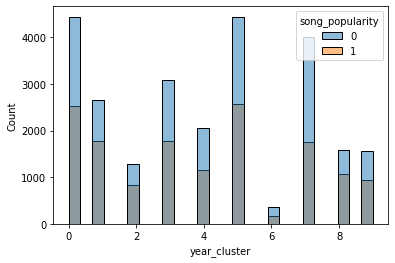

In [925]:
sns.histplot(data=x, x="year_cluster", hue="song_popularity")

# Try out scalers

In [926]:
cont_cols

['acousticness',
 'danceability',
 'liveness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont',
 't_bar',
 'f1',
 'f2',
 'cluster1',
 'cluster2',
 'cluster3']

In [927]:
ss = StandardScaler()
mms = MinMaxScaler()
rs = RobustScaler()

In [928]:
len([i for i in train_idx if i in test_idx]) # =0

0

In [929]:
for scaler in [ss, mms, rs]:
  n_splits=4
  _data_ = x[cont_cols].iloc[train_idx]
  _target_ = x[target_col].iloc[train_idx]
  _data_test = x[cont_cols].iloc[test_idx]
  _target_test = x[target_col].iloc[test_idx]

  _data_ = scaler.fit_transform(_data_)
  _data_test = scaler.transform(_data_test)

  cv_results = cross_validate(LogisticRegression(max_iter=50, solver='liblinear'), _data_, _target_, cv=n_splits, 
                              scoring='roc_auc', return_train_score=True, return_estimator=True)
  
  holdout = sum([m.score(_data_test,_target_test) for m in cv_results['estimator']])/n_splits

  print(f"{scaler.__str__()}, train_cv: {cv_results['train_score'].mean():.6f},  test_cv: {cv_results['test_score'].mean():.6f} holdout: {holdout:.6f}")

StandardScaler(), train_cv: 0.560757,  test_cv: 0.556497 holdout: 0.634950
MinMaxScaler(), train_cv: 0.560823,  test_cv: 0.556673 holdout: 0.634925
RobustScaler(), train_cv: 0.560778,  test_cv: 0.556518 holdout: 0.634950


RobustScaler seems to do best.

In [930]:
x[cont_cols] = rs.fit_transform(x[cont_cols]) # fit and transform the train data
t[cont_cols] = rs.transform(t[cont_cols]) # but only transform for test data

In [931]:
X_train, X_valid, y_train, y_valid = train_test_split(x.drop(target_col, axis=1), x[target_col], test_size=0.2)

Put together the full set into train, valid and test

In [932]:
x = pd.concat([X_train, y_train], axis=1)
v = pd.concat([X_valid, y_valid], axis=1)

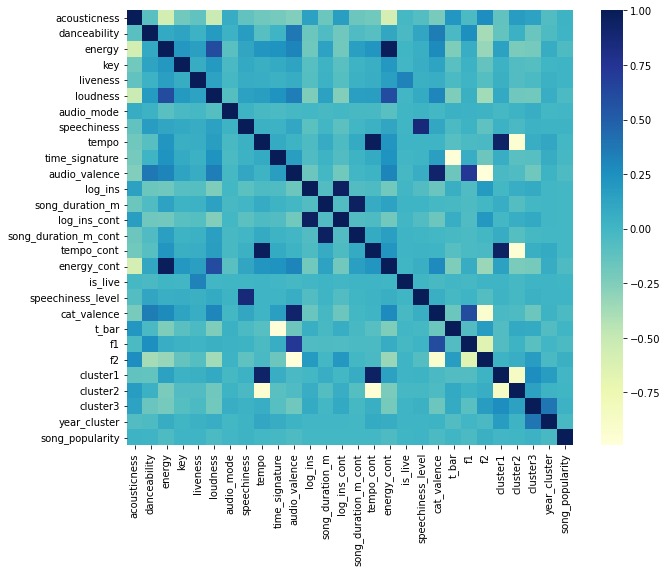

In [933]:
plt.figure(figsize=(10,8))
sns.heatmap(x.corr(), cmap="YlGnBu")

In [934]:
cat_cols

['key',
 'song_duration_m',
 'audio_mode',
 'time_signature',
 'energy',
 'tempo',
 'loudness',
 'log_ins',
 'is_live',
 'speechiness_level',
 'cat_valence',
 'year_cluster']

In [935]:
for c in cat_cols:
  x[c] = x[c].astype('int').astype('category')
  t[c] = t[c].astype('int').astype('category')

# Make Pipeline

In [936]:
x.columns

Index(['acousticness', 'danceability', 'energy', 'key', 'liveness', 'loudness',
       'audio_mode', 'speechiness', 'tempo', 'time_signature', 'audio_valence',
       'log_ins', 'song_duration_m', 'log_ins_cont', 'song_duration_m_cont',
       'tempo_cont', 'energy_cont', 'is_live', 'speechiness_level',
       'cat_valence', 't_bar', 'f1', 'f2', 'cluster1', 'cluster2', 'cluster3',
       'year_cluster', 'song_popularity'],
      dtype='object')

In [937]:
data = x.drop(labels=target_col, axis=1)
target = x.song_popularity
v_data = v.drop(labels=target_col, axis=1)
v_target = v.song_popularity

In [938]:
t_data = t

In [939]:
data.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,cat_valence,t_bar,f1,f2,cluster1,cluster2,cluster3,year_cluster
15586,-0.334029,0.353564,9,9,2.177453,8,1,0.279488,2,3,0.039152,5,3,-0.941849,0.171594,-0.375880,0.841975,0,0,1,0.0,-0.014602,-0.037913,-0.419540,0.383591,0.001961,3
25934,0.454017,-1.443087,5,0,-0.159881,8,0,0.248679,2,4,-0.616532,6,4,0.018613,1.047165,-0.372011,-0.313044,0,0,1,-1.0,-0.173999,0.673406,-0.460666,0.376612,-0.005774,3
20347,-0.228303,0.365228,7,5,-0.670245,7,0,3.695632,0,4,0.559301,5,3,-0.646165,0.124130,-1.174373,0.064011,0,1,2,-1.0,1.545466,-0.493905,-0.136005,1.184701,1.037157,8
17321,-0.389392,-1.507711,3,5,-0.469926,1,0,-0.177104,1,3,-1.125521,9,2,6.468488,-0.770607,-0.872528,-1.105294,0,0,0,0.0,1.394613,1.354122,-0.337048,0.898913,0.695072,1
1505,0.309424,0.006029,7,3,-0.654324,7,1,-0.119758,4,4,0.412787,5,3,-1.127802,-0.402470,0.790692,0.335158,0,0,2,-1.0,0.890520,-0.374001,0.923458,-0.800739,-0.265083,4


In [940]:
data.shape, v_data.shape, t_data.shape

((32000, 27), (8000, 27), (10000, 27))

In [941]:
data.shape, len(cont_cols), len(cat_cols)

((32000, 27), 15, 12)

In [942]:
cat_col_id = [i for i, col_name in enumerate(data.columns.to_list()) if col_name in cat_cols ]

In [943]:
cat_col_id

[2, 3, 5, 6, 8, 9, 11, 12, 17, 18, 19, 26]

In [944]:
model_hgb = make_pipeline(HistGradientBoostingClassifier(scoring='roc_auc', categorical_features=cat_col_id))

In [945]:
n_splits = 8
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# Search for HGB

In [946]:
model_hgb.fit(data,target)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGr

Pipeline(steps=[('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features=[2, 3, 5,
                                                                      6, 8, 9,
                                                                      11, 12,
                                                                      17, 18,
                                                                      19, 26],
                                                scoring='roc_auc'))])

In [947]:
model_hgb.score(data, target), model_hgb.score(v_data, v_target)

(0.6355625, 0.641125)

In [948]:
param_distrib_hgb = {
    'histgradientboostingclassifier__l2_regularization': lognorm(1),
    'histgradientboostingclassifier__learning_rate': lognorm(1),
    'histgradientboostingclassifier__max_depth': [x for x in range(10,300,10)],
    'histgradientboostingclassifier__max_iter': [x for x in range(5,200,20)],
    'histgradientboostingclassifier__max_bins' : [x for x in range(len(cat_col_id),255,10)],
}

In [949]:
search_hgb = RandomizedSearchCV(model_hgb, param_distributions=param_distrib_hgb, 
                                scoring='roc_auc', n_jobs=4, cv=cv, n_iter=100)

In [950]:
search_hgb_results = search_hgb.fit(data, target)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGr

In [951]:
search_hgb_results.best_estimator_.score(data, target), search_hgb_results.best_estimator_.score(v_data, v_target)

(0.63603125, 0.64175)

In [952]:
df_hgb = pd.DataFrame.from_records(search_hgb_results.cv_results_)
df_hgb.columns = [name.split('__')[-1] for name in df_hgb.columns]
df_hgb = df_hgb[[name for name in df_hgb.columns if 'time' not in name]]
df_hgb = df_hgb.sort_values(by='rank_test_score').head(10)
df_hgb

,mean_test_score,l2_regularization,learning_rate,max_bins,max_depth,max_iter,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,std_test_score
31,0.564455,2.24184,0.0983819,62,260,165,{'histgradientboostingclassifier__l2_regulariz...,1,0.567017,0.557277,0.550867,0.574300,0.569838,0.579824,0.570660,0.545861,0.011119
91,0.563217,3.33364,0.1006,162,90,125,{'histgradientboostingclassifier__l2_regulariz...,2,0.563967,0.553405,0.556563,0.569397,0.570161,0.575643,0.571439,0.545164,0.009845
0,0.560046,0.726925,0.173768,72,10,145,{'histgradientboostingclassifier__l2_regulariz...,3,0.563003,0.558585,0.553124,0.566245,0.564633,0.567912,0.564528,0.542342,0.008013
80,0.559620,4.82765,0.165129,112,220,145,{'histgradientboostingclassifier__l2_regulariz...,4,0.560295,0.551383,0.550859,0.564941,0.566674,0.576898,0.561042,0.544868,0.009626
99,0.558487,0.955128,0.209563,102,50,105,{'histgradientboostingclassifier__l2_regulariz...,5,0.572371,0.553734,0.541191,0.566221,0.564674,0.564173,0.561383,0.544150,0.010361
67,0.558139,0.573964,0.150687,82,10,165,{'histgradientboostingclassifier__l2_regulariz...,6,0.553290,0.550626,0.544943,0.571271,0.572923,0.570371,0.553377,0.548314,0.010688
56,0.558089,2.14058,0.164428,32,50,165,{'histgradientboostingclassifier__l2_regulariz...,7,0.556798,0.551643,0.552571,0.570662,0.572515,0.560396,0.557629,0.542502,0.009276
73,0.558081,0.371166,0.323277,252,160,5,{'histgradientboostingclassifier__l2_regulariz...,8,0.557668,0.561344,0.544512,0.559835,0.570550,0.574333,0.553007,0.543395,0.010362
86,0.557449,0.258516,0.184304,232,270,65,{'histgradientboostingclassifier__l2_regulariz...,9,0.559912,0.548383,0.542879,0.556213,0.574596,0.569017,0.560097,0.548500,0.010106
43,0.556650,0.458205,0.22347,22,260,85,{'histgradientboostingclassifier__l2_regulariz...,10,0.553179,0.554434,0.548865,0.567384,0.566064,0.570182,0.550069,0.543023,0.009311


In [953]:
best_hgb = search_hgb_results.best_estimator_

# Search for LR

In [954]:
model_lr = make_pipeline(LogisticRegression(solver='liblinear'))

In [955]:
model_lr.fit(data,target)

Pipeline(steps=[('logisticregression', LogisticRegression(solver='liblinear'))])

In [956]:
model_lr.score(data, target), model_lr.score(v_data, v_target)

(0.63353125, 0.642375)

In [957]:
param_distrib_lr = {
    'logisticregression__C': lognorm(1),
    'logisticregression__l1_ratio': lognorm(1),
    'logisticregression__warm_start': [True, False],
}

In [958]:
search_lr = RandomizedSearchCV(model_lr, param_distributions=param_distrib_lr, 
                                scoring='roc_auc', n_jobs=4, cv=cv, n_iter=100)

In [959]:
search_lr_results = search_lr.fit(data, target)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


In [960]:
search_lr_results.best_estimator_.score(data, target), search_lr_results.best_estimator_.score(v_data, v_target)

(0.6334375, 0.642125)

In [961]:
df_lr = pd.DataFrame.from_records(search_lr_results.cv_results_)
df_lr.columns = [name.split('__')[-1] for name in df_lr.columns]
df_lr = df_lr[[name for name in df_lr.columns if 'time' not in name]]
df_lr = df_lr.sort_values(by='rank_test_score').head(10)
df_lr

,mean_test_score,C,l1_ratio,warm_start,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,std_test_score
78,0.556517,0.135436,0.791352,True,"{'logisticregression__C': 0.13543567142200863,...",1,0.555656,0.540123,0.557321,0.570657,0.552082,0.565759,0.568100,0.542436,0.010651
41,0.556503,0.176703,0.708758,False,"{'logisticregression__C': 0.17670273942583747,...",2,0.555693,0.540094,0.557290,0.570681,0.552082,0.565848,0.567949,0.542384,0.010658
22,0.556496,0.150388,0.678713,False,"{'logisticregression__C': 0.15038798052215094,...",3,0.555669,0.540113,0.557323,0.570615,0.552052,0.565756,0.568031,0.542408,0.010643
54,0.556483,0.189198,1.38624,False,"{'logisticregression__C': 0.18919804794715997,...",4,0.555702,0.540116,0.557299,0.570567,0.552072,0.565880,0.567896,0.542334,0.010640
85,0.556483,0.151033,0.490157,False,"{'logisticregression__C': 0.15103265223282636,...",5,0.555650,0.540075,0.557329,0.570609,0.552056,0.565690,0.568028,0.542427,0.010638
37,0.556481,0.206917,0.868905,False,"{'logisticregression__C': 0.20691718021128674,...",6,0.555691,0.540096,0.557337,0.570536,0.552080,0.565914,0.567880,0.542310,0.010645
32,0.556471,0.206867,0.724358,False,"{'logisticregression__C': 0.20686704446577178,...",7,0.555691,0.540092,0.557282,0.570538,0.552063,0.565912,0.567879,0.542311,0.010646
58,0.556470,0.182006,3.21272,True,"{'logisticregression__C': 0.18200627350413998,...",8,0.555689,0.540097,0.557307,0.570538,0.552072,0.565859,0.567882,0.542312,0.010639
65,0.556468,0.238169,2.65458,False,"{'logisticregression__C': 0.23816887425304936,...",9,0.555708,0.540062,0.557311,0.570575,0.552068,0.565927,0.567804,0.542285,0.010653
80,0.556466,0.229384,0.382187,False,"{'logisticregression__C': 0.22938447503767503,...",10,0.555694,0.540091,0.557291,0.570577,0.552076,0.565954,0.567760,0.542283,0.010645


In [962]:
best_lr = search_lr_results.best_estimator_

# Retrain on whole data for all best models

In [963]:
data_ = pd.concat([data, v_data], axis=0)
target_ = pd.concat([target, v_target], axis=0)

In [964]:
full = pd.concat([data_, target_], axis=1)

In [965]:
full.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,cat_valence,t_bar,f1,f2,cluster1,cluster2,cluster3,year_cluster,song_popularity
15586,-0.334029,0.353564,9.0,9.0,2.177453,8.0,1,0.279488,2.0,3,0.039152,5.0,3.0,-0.941849,0.171594,-0.375880,0.841975,0,0.0,1.0,0.0,-0.014602,-0.037913,-0.419540,0.383591,0.001961,3,0
25934,0.454017,-1.443087,5.0,0.0,-0.159881,8.0,0,0.248679,2.0,4,-0.616532,6.0,4.0,0.018613,1.047165,-0.372011,-0.313044,0,0.0,1.0,-1.0,-0.173999,0.673406,-0.460666,0.376612,-0.005774,3,1
20347,-0.228303,0.365228,7.0,5.0,-0.670245,7.0,0,3.695632,0.0,4,0.559301,5.0,3.0,-0.646165,0.124130,-1.174373,0.064011,0,1.0,2.0,-1.0,1.545466,-0.493905,-0.136005,1.184701,1.037157,8,0
17321,-0.389392,-1.507711,3.0,5.0,-0.469926,1.0,0,-0.177104,1.0,3,-1.125521,9.0,2.0,6.468488,-0.770607,-0.872528,-1.105294,0,0.0,0.0,0.0,1.394613,1.354122,-0.337048,0.898913,0.695072,1,1
1505,0.309424,0.006029,7.0,3.0,-0.654324,7.0,1,-0.119758,4.0,4,0.412787,5.0,3.0,-1.127802,-0.402470,0.790692,0.335158,0,0.0,2.0,-1.0,0.890520,-0.374001,0.923458,-0.800739,-0.265083,4,0


In [966]:
for m in [best_lr, best_hgb]:
  cv_results = cross_validate(m, data_, target_, cv=cv, 
                              scoring='roc_auc', 
                              return_train_score=True, return_estimator=True)
  tr_s, te_s = cv_results['train_score'].mean(), cv_results['test_score'].mean()
  print(f"model: {m.steps[-1][0]}, train score: {tr_s}, test score: {te_s}")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

model: logisticregression, train score: 0.5622824613808748, test score: 0.5582867152673533


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGr

model: histgradientboostingclassifier, train score: 0.6776906403567894, test score: 0.5689013129853362


# Inference

In [967]:
best_hgb

Pipeline(steps=[('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features=[2, 3, 5,
                                                                      6, 8, 9,
                                                                      11, 12,
                                                                      17, 18,
                                                                      19, 26],
                                                l2_regularization=2.2418404971113213,
                                                learning_rate=0.09838186762984037,
                                                max_bins=62, max_depth=260,
                                                max_iter=165,
                                                scoring='roc_auc'))])

In [982]:
cv_results = cross_validate(best_hgb, data_, target_, cv=cv, 
                              scoring='roc_auc', return_train_score=True, return_estimator=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but HistGr

In [983]:
len(cv_results['estimator'])

8

In [984]:
cv_results['train_score'].mean(), cv_results['test_score'].mean()

(0.6489483427050917, 0.5646857507431373)

In [985]:
t_data.shape

(10000, 27)

In [986]:
test_preds_ = np.asarray([m.predict_proba(t_data)[:,1] for m in cv_results['estimator']])

In [987]:
test_preds = pd.DataFrame(test_preds_.T, columns=[f'pred_{i}' for i in range(len(cv_results['estimator']))])
test_preds[target_col] = test_preds.mean(1)
test_preds["id"] = test_preds.reset_index()["index"]

In [988]:

test_preds.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,song_popularity,id
0,0.387699,0.418732,0.411334,0.440477,0.378558,0.395145,0.398423,0.435227,0.408199,0
1,0.403897,0.441071,0.429661,0.460701,0.395830,0.433994,0.414581,0.434443,0.426772,1
2,0.343754,0.278662,0.286630,0.257491,0.306037,0.305671,0.355146,0.368607,0.312750,2
3,0.371663,0.394347,0.391316,0.310428,0.336583,0.362140,0.424355,0.430973,0.377726,3
4,0.391938,0.398611,0.344207,0.380592,0.393936,0.395746,0.365074,0.375406,0.380689,4


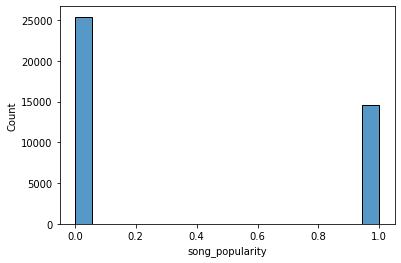

In [989]:
sns.histplot(data=full, x=target_col)

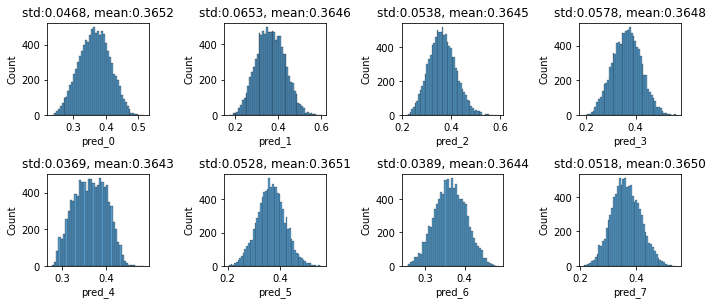

In [990]:
plt.figure(figsize=(10,6))
for i in range(len(cv_results['estimator'])):
  plt.subplot(3, 4, i+1)
  sns.histplot(data=test_preds, x=f'pred_{i}')
  std, mn = test_preds[f"pred_{i}"].std(), test_preds[f"pred_{i}"].mean()
  plt.title(f'std:{std:.4f}, mean:{mn:.4f}')
  plt.tight_layout()

In [991]:
result = test_preds[["id", target_col]]
result.columns = ['id', target_col]

In [992]:
result.head()

,id,song_popularity
0,0,0.408199
1,1,0.426772
2,2,0.312750
3,3,0.377726
4,4,0.380689


In [993]:
result.to_csv('submission.csv', index=False)

In [994]:
! kaggle competitions submit -c song-popularity-prediction -f submission.csv -m "HGB Trees RandomSearchCV=10, l2 regularisation"

100% 237k/237k [00:00<00:00, 887kB/s]
400 - Bad Request
